#**VISA** Assignment
Puranjay Kwatra, 9306614548, kwattrapuranjay@gmail.com

## Identifying fraudulent users from multiple samples from the same user.

### Understanding the Problem and the data
---

*   92 Users ---> 47[Fraud] and 45[Non-fraud]    File(user-level fraud indicator)

*   Features- Total 166


*   Activity Records=476 File(fraud-user-and-transactions-dat)



We are provided with two sheets:

User-level Fraud Indicator

Fraudulent Users and Transactions Data

Merge the two sheets using the user_id as the key. This will allow us to align the user-level fraud labels with their corresponding transaction records for further analysis.


In [100]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

file_path = "fraud-user-and-transactions-data.xlsx"
excel_file = pd.ExcelFile(file_path)
#Dividing the data from sheets
y_df = excel_file.parse("user-level fraud indicator")
X_df = excel_file.parse("fraud-user-and-transactions-dat")

y_df.columns = ["user-id", "fraud"]

# Merge fraud label into activity data
X_merged = pd.merge(X_df, y_df, on="user-id", how="left")

print(X_merged.head())

  user-id  f1   f2   f3  f4   f5  f6  f7   f8  f9  ...  f158  f159  f160  \
0   uid-1  42 -198 -109 -75 -117  11  23  -88 -28  ...   -74  -129  -120   
1   uid-1  42 -191 -142 -65 -117  55  49 -170 -45  ...  -302    60  -120   
2   uid-1  42 -191 -142 -75 -117  11  49 -161 -45  ...   -73  -127  -120   
3   uid-1  42 -198 -110 -65 -117  55  23  -95 -28  ...  -302    60  -120   
4   uid-2  42 -198 -102 -75 -117  10  24  -87 -28  ...   -73  -127    51   

   f161  f162  f163  f164  f165  f166  fraud  
0   -38    30    48   -37     6    30      1  
1   -39    31    48   -37     5    30      1  
2   -38    30    48   -37     5    31      1  
3   -39    30    48   -37     6    30      1  
4   128   144    43   -30    14    26      1  

[5 rows x 168 columns]




>  Now In order to Get the More detailed features lets Aggregate the data per use for mean , std, max so that we have clear picture about the features patterns

**Why are we doing this?**


1.   Mean - Using mean I can have the central data points of the activity
2.   STD- Using STD to mesaure Variance
3. MAX- Since I already know this is credit card data this can give us if there is a max spend from the amounts or transaction from all the features




In [101]:
# Using  mean, std, and max for each feature
agg_funcs = ['mean', 'std', 'max']
X_user = X_merged.groupby("user-id").agg({f"f{i}": agg_funcs for i in range(1, 167)})
X_user.columns = [f"{feat}_{agg}" for feat, agg in X_user.columns]
# Reset index to bring user-id as a column
X_user = X_user.reset_index()
print(X_user.head())




  user-id  f1_mean    f1_std  f1_max  f2_mean      f2_std  f2_max     f3_mean  \
0   uid-1   42.000  0.000000      42 -194.500    4.041452    -191 -125.750000   
1  uid-10   44.000  9.859006      53 -155.000   46.017388    -112  -85.833333   
2  uid-11   42.200  9.859006      53 -146.200   45.920584    -112  -73.000000   
3  uid-12   43.625  5.680480      52 -142.875   53.504172     -59  -96.750000   
4  uid-13   40.000  3.464102      43  -36.000  140.325811      86  -74.250000   

      f3_std  f3_max  ...  f163_max  f164_mean  f164_std  f164_max  f165_mean  \
0  18.768324    -109  ...        48    -37.000  0.000000       -37   5.500000   
1  70.782531     -21  ...        56    -39.000  5.477226       -34   3.166667   
2  70.897814     -21  ...        56    -38.000  5.477226       -34   5.200000   
3  64.340056     -19  ...       100    -31.875  9.789754       -13  -6.125000   
4  89.362091       4  ...        86    -32.500  4.041452       -29 -15.000000   

    f165_std  f165_max  f1

Merge aggregated features with fraud labels based on user-id. just like sql I am using a left join

In [102]:
# Merge again with fraud labels
y_user = pd.merge(X_user, y_df, on="user-id", how="left")
print(y_user.head())

  user-id  f1_mean    f1_std  f1_max  f2_mean      f2_std  f2_max     f3_mean  \
0   uid-1   42.000  0.000000      42 -194.500    4.041452    -191 -125.750000   
1  uid-10   44.000  9.859006      53 -155.000   46.017388    -112  -85.833333   
2  uid-11   42.200  9.859006      53 -146.200   45.920584    -112  -73.000000   
3  uid-12   43.625  5.680480      52 -142.875   53.504172     -59  -96.750000   
4  uid-13   40.000  3.464102      43  -36.000  140.325811      86  -74.250000   

      f3_std  f3_max  ...  f164_mean  f164_std  f164_max  f165_mean  \
0  18.768324    -109  ...    -37.000  0.000000       -37   5.500000   
1  70.782531     -21  ...    -39.000  5.477226       -34   3.166667   
2  70.897814     -21  ...    -38.000  5.477226       -34   5.200000   
3  64.340056     -19  ...    -31.875  9.789754       -13  -6.125000   
4  89.362091       4  ...    -32.500  4.041452       -29 -15.000000   

    f165_std  f165_max  f166_mean   f166_std  f166_max  fraud  
0   0.577350         6


## > **Model Testing Strategy**<br>
I will begin by testing Random Forest, as it effectively handles complex and high-dimensional features with minimal preprocessing. It's a strong baseline for structured data and offers feature importance insights.
After this, I will evaluate two additional models:



*   XGBoost, using binary cross-entropy (log loss) as the objective, known for its performance on tabular data.
*   Logistic Regression, for its simplicity and interpretaility serving as a reliable linear baseline model beacuse our solution is solely based on predict a binary output






In [103]:
# Features and labels
from sklearn.metrics import classification_report, confusion_matrix
X = y_user.drop(columns=["user-id", "fraud"])
y = y_user["fraud"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.89      0.76         9
           1       0.86      0.60      0.71        10

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19

Confusion Matrix:
 [[8 1]
 [4 6]]


In [104]:
from sklearn.metrics import roc_auc_score
print("Random Forest ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


Random Forest ROC AUC Score: 0.9111111111111112


Random Forest isn’t giving good accuracy, there are more false negatives so let’s try improving it by adding class_weight to handle class imbalance.

Train Random Forest with balanced class weights and evaluate performance.

In [105]:
model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.89      0.80      0.84        10

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19

Confusion Matrix:
 [[8 1]
 [2 8]]


In [106]:
from sklearn.metrics import roc_auc_score
print("AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


AUC Score: 0.9277777777777778


### :Calculate AUC, plot ROC curve, and visualize model performance.
### Since Our AUC is closer to 1 its classifing very perfectly

ROC AUC Score: 0.9277777777777778


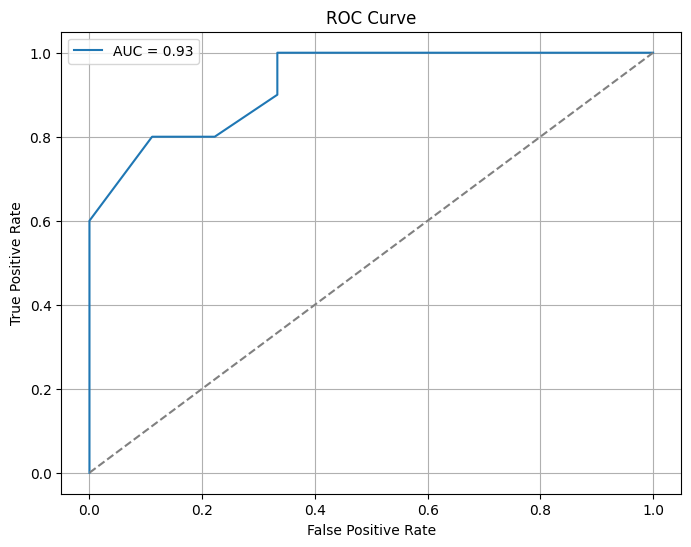

In [107]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get probabilities instead of hard class predictions
y_probs = model.predict_proba(X_test)[:, 1] # adding [:,1] adds probability of fraud

# AUC score
auc_score = roc_auc_score(y_test, y_probs)
print("ROC AUC Score:", auc_score)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot it
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # random line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


## Model Number 2: LogisticRegression



> So Our Random Forest is giving a good accuracy but inorder to compare it with some better models , The ideal approach should be to test with the other models and compare the score so mainly for BinaryClassification problem I am going with ROC



In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Create model with class weight to handle imbalance
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')
# Choosing liblinear as its best for small datasets

# Train
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)
y_probs = logreg.predict_proba(X_test)[:, 1]

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_probs))



Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.82      0.90      0.86        10

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19

ROC AUC Score: 0.8666666666666667


## XGBOOST

> Since Logistic Regression isn’t performing well, let's try XGBoost with a custom loss function like log loss.

Train XGBoost with custom log loss objective, evaluate using classification report and ROC AUC score.



In [125]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize model
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=1,
    n_estimators=100,
    learning_rate=0.23, # chanding the learning rate from 0.1 to 0.23 signifincatly increased the accuracy from 89.99 to 97.23
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

# Predict
y_pred = xgb.predict(X_test)
y_probs = xgb.predict_proba(X_test)[:, 1]

# Evaluate
print("\n\n\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_probs))





Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        54
           1       0.95      0.95      0.95        42

    accuracy                           0.96        96
   macro avg       0.96      0.96      0.96        96
weighted avg       0.96      0.96      0.96        96

ROC AUC Score: 0.9739858906525574


So lets find out which feature is influencing our prediction the most

```
Feature can be anything ex: Trasnaction,Charges
```



<Figure size 1000x600 with 0 Axes>

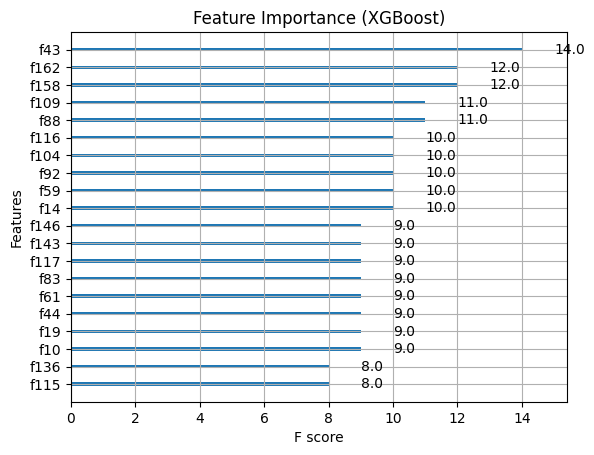

In [127]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(xgb, max_num_features=20)  # Top 20 features
plt.title("Feature Importance (XGBoost)")
plt.show()


Lets check Our best Other model Features which Feature were most important

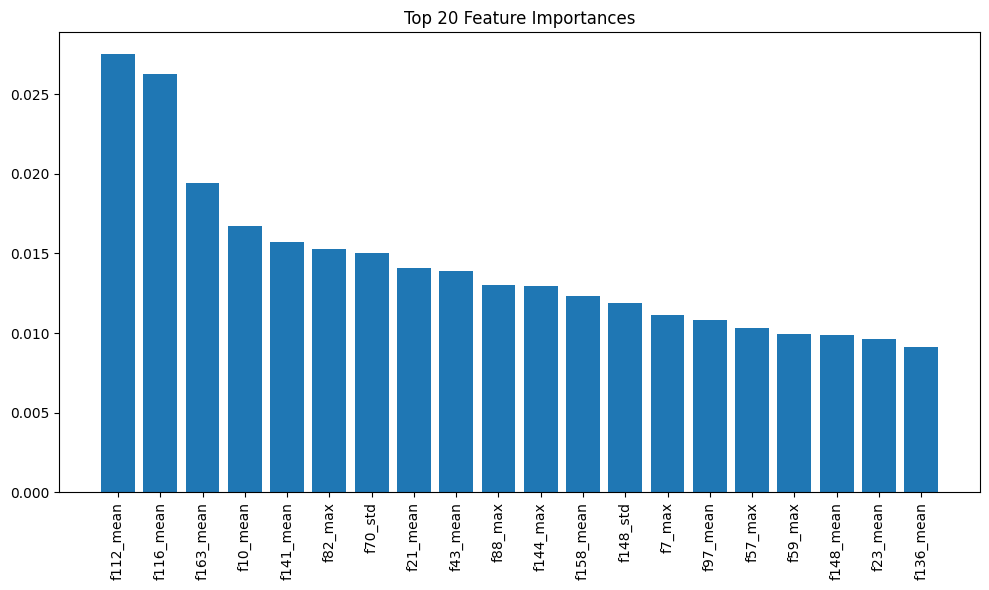

In [128]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:20]  # Top 20

plt.figure(figsize=(10,6))
plt.title("Top 20 Feature Importances")
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


## @With This we can conclude that featuresd f112, and f116 are top features that are influncing the results.

Lets Understand more features in the dataset Using ***GirdSearchCV*** max_depth, learning_rate, n_estimators in XGBoost

1.   Takes a list of hyperparmaters and values

2.   Training the model with every combination

3.  Uses cross-validation (e.g. 5-fold) to estimate performance

4. Picks the best one based on your chosen metric (e.g. AUC)

In [112]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.03, 0.1],
    'n_estimators': [100, 195],
    'subsample': [0.7, 0.9]
}

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',     us
    cv=5,                  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1              # Use all CPU cores for faster search
)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:01:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Best AUC Score: 0.8795918367346939


In [113]:
best_xgb = grid_search.best_estimator_

# Predict on test set
y_pred = best_xgb.predict(X_test)
y_probs = best_xgb.predict_proba(X_test)[:, 1]

# Evaluate performance
from sklearn.metrics import classification_report, roc_auc_score

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test ROC AUC Score:", roc_auc_score(y_test, y_probs))


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.89      0.80      0.84        10

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19

Test ROC AUC Score: 0.9


# Bonus Part
Predict the Individual Fraud Label for each activity record



*   We have predicted Individual User with a decent accuracy
*   Now what we want is to predict the activity level fraud detection



### Bonus Part: Predict individual fraud labels for each activity record.

### After achieving decent accuracy at the user level, we aim to predict fraud detection at the activity level.


In [114]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

Load the activity data and reuse the merged data (X_merged) for predicting individual fraud labels.


In [115]:
activity_df = excel_file.parse("fraud-user-and-transactions-dat")
# Lets use X_merged again beacuse we will need that merged data again
activity_df=X_merged

In [116]:
print(activity_df.head())
x=activity_df[[f'f{i}' for i in range(1, 167)]]
# print(x)
y=activity_df['fraud']

  user-id  f1   f2   f3  f4   f5  f6  f7   f8  f9  ...  f158  f159  f160  \
0   uid-1  42 -198 -109 -75 -117  11  23  -88 -28  ...   -74  -129  -120   
1   uid-1  42 -191 -142 -65 -117  55  49 -170 -45  ...  -302    60  -120   
2   uid-1  42 -191 -142 -75 -117  11  49 -161 -45  ...   -73  -127  -120   
3   uid-1  42 -198 -110 -65 -117  55  23  -95 -28  ...  -302    60  -120   
4   uid-2  42 -198 -102 -75 -117  10  24  -87 -28  ...   -73  -127    51   

   f161  f162  f163  f164  f165  f166  fraud  
0   -38    30    48   -37     6    30      1  
1   -39    31    48   -37     5    30      1  
2   -38    30    48   -37     5    31      1  
3   -39    30    48   -37     6    30      1  
4   128   144    43   -30    14    26      1  

[5 rows x 168 columns]


Splittting the data into Train and test split

In [117]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

Using **Binary cross ENtropy loss** as this is a binray classification problem that we are working on

*   USE_LABEL_ENCODER= since we already appended the fraud labels column we dont need this




In [118]:
scale = (y_train == 0).sum() / (y_train == 1).sum()  # for imbalance handling
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale,
    random_state=42
)
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:01:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [129]:
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

In [130]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(" Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

print(" ROC AUC Score:", roc_auc_score(y_test, y_prob))


 Classification Report:

              precision    recall  f1-score   support

           0     0.9273    0.9444    0.9358        54
           1     0.9268    0.9048    0.9157        42

    accuracy                         0.9271        96
   macro avg     0.9271    0.9246    0.9257        96
weighted avg     0.9271    0.9271    0.9270        96

 ROC AUC Score: 0.9805996472663139


###  Confusion Matrix for Activity-Level Prediction

- Computes the confusion matrix using `y_test` (true labels) and `y_pred` (model predictions).
- Visualizes the matrix using a heatmap for better readability.
- Shows:
  - **True Positives (TP)**: Correctly predicted frauds.
  - **True Negatives (TN)**: Correctly predicted non-frauds.
  - **False Positives (FP)**: Non-frauds incorrectly predicted as frauds.
  - **False Negatives (FN)**: Frauds missed by the model.



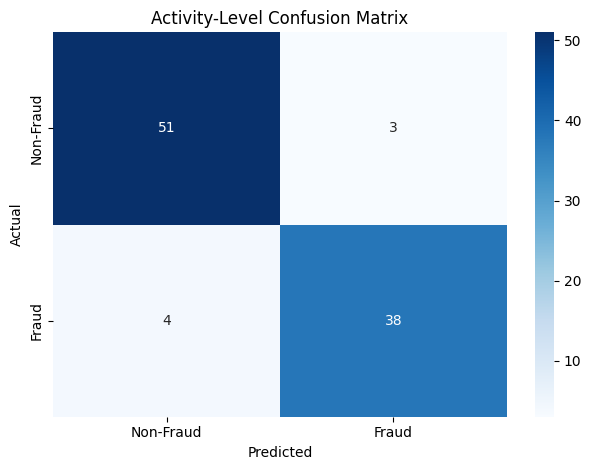

In [121]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Activity-Level Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Testing and Prediction Validation

To test the Activity level prediction lets call over trained model that we used and manually pass a UID and see the Prediction wether it is  `Fraud` or `Not Fraud`




In [122]:
target_user_id = 'uid-60'
# Filter all activities of that user that we mentioned above
user_activities = activity_df[activity_df['user-id'] == target_user_id].copy()
# Extract features only so that we can predit on the basis of these features only
X_user = user_activities[[f'f{i}' for i in range(1, 167)]]

# Predict fraud probabilities
user_activities['fraud_probability'] = xgb_model.predict_proba(X_user)[:, 1]
user_activities['fraud_prediction'] = xgb_model.predict(X_user)

# Showing only the Top 5 probabilities and there prediction.
user_activities_sorted = user_activities.sort_values(by='fraud_probability', ascending=False)
print("\nTop suspicious activities for user:", target_user_id)
print(user_activities_sorted[['user-id', 'fraud_prediction', 'fraud_probability']].head(5))



Top suspicious activities for user: uid-60
    user-id  fraud_prediction  fraud_probability
255  uid-60                 1           0.659035
264  uid-60                 0           0.186294
270  uid-60                 0           0.161318
278  uid-60                 0           0.117823
265  uid-60                 0           0.117642
